## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable
%matplotlib widget

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [2]:
def scale(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def descale(X, X_old):
    return (X_old.max(axis=0) - X_old.min(axis=0)) * X + X_old.min(axis=0)

# plot train and validation loss
%matplotlib widget

def plot_loss(loss, val_loss, epoch=(-1, -1)):
    fig = plt.figure()

    if epoch[0] == -1:
        start_idx = 0
    else:
        start_idx = epoch[0]

    if epoch[1] == -1:
        end_idx = len(loss)
    else:
        end_idx = epoch[1]
    loss = loss[start_idx: end_idx]
    val_loss = val_loss[start_idx: end_idx]
    plt.plot(np.arange(start_idx, end_idx), loss, label='train')
    plt.plot(np.arange(start_idx, end_idx), val_loss, label='validation')
    plt.title('Model Accuracy')
    plt.ylabel(criterion_name)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    plt.close()




In [3]:
# Load the data
# df = pd.read_pickle('./data/transfer-functions.pkl')
df = pd.read_pickle('./data/transfer-functions-82000.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.000100,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.425862483348567, -34.50558003150795, -39...."
1,-20.0,0.000621,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-17.111296708758623, -19.276097087349733, -21..."
2,-20.0,0.001142,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-37.10041261060839, -21.007891272269745, -20...."
3,-20.0,0.001663,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-23.37838521227782, -24.835608713413627, -24...."
4,-20.0,0.002184,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.79184944021594, -28.996907099851697, -27...."


In [4]:
# quantize the output features
# factorized, uniques = pd.factorize(df['phi'])
# print(uniques)
# df['phi'] = factorized

# factorized, uniques = pd.factorize(df['g_oo'])
# print(uniques)
# df['g_oo'] = factorized


phi_encoder = preprocessing.LabelEncoder()
df['phi_label'] = phi_encoder.fit_transform(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
df['g_oo_label'] = gain_encoder.fit_transform(df['g_oo'])
print(gain_encoder.classes_)


print(df.dtypes)



[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.0001     0.00062105 0.00114211 0.00166316 0.00218421 0.00270526
 0.00322632 0.00374737 0.00426842 0.00478947 0.00531053 0.00583158
 0.00635263 0.00687368 0.00739474 0.00791579 0.00843684 0.00895789
 0.00947895 0.01      ]
phi           float64
g_oo          float64
x              object
y              object
phi_label       int64
g_oo_label      int64
dtype: object


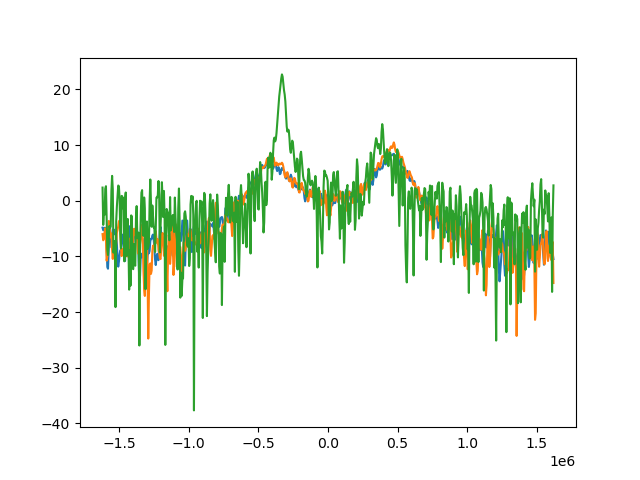

In [5]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [6]:
# Extract the target variables
param_a_label = df.pop('phi_label')
param_b_label = df.pop('g_oo_label')

param_a = df.pop('phi')
param_b = df.pop('g_oo')


# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [7]:
# target is the target vector
target = np.array((param_a_label, param_b_label), dtype=np.uint8).T

target_original = np.array((param_a, param_b)).T

# scaled_target = scale(target)
# target_scaler = preprocessing.StandardScaler().fit(target)
# print(target_scaler.mean_)
# print(target_scaler.scale_)
# scaled_target = target_scaler.transform(target)
target = torch.tensor(target, dtype=torch.uint8)
print(target[5:15])
# scaler_target = preprocessing.MinMaxScaler()
# scaled_target = torch.tensor(scaled_target)
# print(scaled_target[5:15])

tensor([[ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14]], dtype=torch.uint8)


In [8]:
# Only the input points have been left
df.head()

,y
0,"[-22.425862483348567, -34.50558003150795, -39...."
1,"[-17.111296708758623, -19.276097087349733, -21..."
2,"[-37.10041261060839, -21.007891272269745, -20...."
3,"[-23.37838521227782, -24.835608713413627, -24...."
4,"[-21.79184944021594, -28.996907099851697, -27...."


In [9]:
values = np.zeros((len(df), len(df.iloc[0,0])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row.values[0]
    index += 1
print(values.shape)
print(type(values))

(82000, 662)
<class 'numpy.ndarray'>


In [10]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
# scaled_values = scale(values)
scaled_values = data_scaler.transform(values)
# scaled_values = values
# print(data_scaler.mean_)
# print(data_scaler.scale_)
data = torch.tensor(scaled_values)
# data = torch.tensor(values, dtype=torch.float32)
print(data)

tensor([[-1.2695, -2.2140, -2.7280,  ..., -0.9453, -1.3646, -2.3427],
        [-0.7820, -0.7954, -0.9861,  ..., -0.7045, -0.7330, -2.1319],
        [-2.6156, -0.9567, -0.9385,  ..., -0.9320, -1.0220, -1.4074],
        ...,
        [ 0.1626,  0.3590,  0.2569,  ..., -0.3814, -0.2362,  0.3938],
        [-0.3497,  0.5654,  0.5511,  ...,  0.5762,  0.7127,  0.0781],
        [-0.0635,  0.6010,  0.6840,  ...,  0.0100,  0.1177,  0.4430]])


In [11]:
# Split in train and test
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(data, target, target_original, test_size=0.2, random_state=2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([65600, 662])
torch.Size([16400, 662])
torch.Size([65600, 2])
torch.Size([16400, 2])


In [12]:
# Define the network architecture2

class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, name='classifer', activation_func=F.gelu,
                 hidden_1=140, hidden_2=110, hidden_3=0,
                 kernel_size=10, stride=10, trim_edges=120, save_best=True):
        super(Net, self).__init__()
        self.activate = activation_func
        self.name = name
        self.save_best = save_best
        # A layer that trims out the edges
        self.center = nn.ConstantPad1d(-trim_edges, 0)
        n_inputs -= 2 * trim_edges
        # An avgpooling layer to smoothen the curve
        padding = 0
        n_pool_out = (n_inputs + 2 * padding - kernel_size)//stride +1
        self.pool1 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)

        # linear layer (n_pool_out -> hidden_1)
        self.fc1 = nn.Linear(n_pool_out, hidden_1)

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)

        # linear layer (n_hidden -> n_outputs)
        if hidden_3 > 0:
            self.fc3 = nn.Linear(hidden_2, hidden_3)
            self.fc4 = nn.Linear(hidden_3, n_outputs)
        else:
            self.fc3 = nn.Linear(hidden_2, n_outputs)
            self.fc4 = None

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # remove some points from the edges
        x = self.center(x)

        # This performs the average pooling layer
        x = self.pool1(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        if self.fc4:
            x = self.dropout(self.activate(self.fc3(x)))
            # add outputlayer
            x = self.fc4(x)
        else:
            # add output layer
            x = self.fc3(x)

        # Output layer with softmax activation
        x = F.log_softmax(x, dim=1)

        return x


    def get_accuracy(self, log_probs, labels):
        ps = torch.exp(log_probs)
        top_p, top_class = ps.topk(1, dim=1)
        # print(top_class.shape)
        # print(top_class.view(-1)[:5])
        # print(labels.shape)
        # print(labels.view(-1)[:5])
        n_correct = top_class == labels.view(*top_class.shape)
        # n_correct = torch.eq(top_class.view(-1,), labels.view(-1))
        # print(n_correct.sum().item())
        # n_correct = torch.sum((torch.abs(pred_arr-original_arr) < torch.abs(pct * original_arr)))
        acc = (n_correct.sum().item() * 100.0 / len(labels))
        return acc


    def save(self, name='model.pt'):
        torch.save(self.state_dict(), name)


    def train_net(self, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=100):
        l_train_loss=[]
        l_train_accuracy=[]
        l_test_loss=[]
        l_test_accuracy=[]
        min_test_loss = np.Inf
        for epoch in range(num_epochs):
            # put the model in training mode
            self.train()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output_train = self(X_train)

            l_train_accuracy.append(self.get_accuracy(output_train, y_train))

            #calculate the loss
            train_loss = criterion(output_train, y_train)
            l_train_loss.append(train_loss.item())

            #backward pass: compute gradient of the loss with respect to model parameters
            train_loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            with torch.no_grad():
                output_test = self(X_test)
                test_loss = criterion(output_test, y_test)
                l_test_loss.append(test_loss.item())
                l_test_accuracy.append(self.get_accuracy(output_test, y_test))

            if l_test_loss[-1] < min_test_loss:
                print(f"Epoch {epoch+1}/{num_epochs}: Test loss decreased ({min_test_loss:.6f} --> {l_test_loss[-1]:.6f})")
                if self.save_best:
                    self.save(f'models/{self.name}.pt')
                min_test_loss = l_test_loss[-1]

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {l_train_loss[-1]:.4f}, Test Loss: {l_test_loss[-1]:.4f}")

        return l_train_loss, l_train_accuracy, l_test_loss, l_test_accuracy


In [13]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 0]))
model1 = Net(n_inputs, n_outputs, name='classifier1', activation_func=F.gelu,
                hidden_1=420, hidden_2=140, hidden_3=0,
                kernel_size=4, stride=4, trim_edges=110, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss(); criterion_name = 'NLL'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-110, -110), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=110, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=140, bias=True)
  (fc3): Linear(in_features=140, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [20]:
# train the network
train_loss1, train_accuracy1, test_loss1, test_accuracy1 = model1.train_net(
    optimizer1, criterion, X_train, y_train[:, 0].view(-1,), X_test, y_test[:, 0].view(-1,), 500)

Epoch 1/500: Test loss decreased (inf --> 3.681160)
Epoch 2/500: Test loss decreased (3.681160 --> 3.579135)
Epoch 4/500: Test loss decreased (3.579135 --> 3.328834)
Epoch 6/500: Test loss decreased (3.328834 --> 3.178421)
Epoch 8/500: Test loss decreased (3.178421 --> 3.093310)
Epoch 9/500: Test loss decreased (3.093310 --> 3.025487)
Epoch 10/500: Test loss decreased (3.025487 --> 2.968563)
Epoch 11/500: Test loss decreased (2.968563 --> 2.850619)
Epoch 12/500: Test loss decreased (2.850619 --> 2.778754)
Epoch 13/500: Test loss decreased (2.778754 --> 2.748724)
Epoch 14/500: Test loss decreased (2.748724 --> 2.672981)
Epoch 15/500: Test loss decreased (2.672981 --> 2.593819)
Epoch 16/500: Test loss decreased (2.593819 --> 2.552511)
Epoch 19/500: Test loss decreased (2.552511 --> 2.514787)
Epoch 21/500: Test loss decreased (2.514787 --> 2.509697)
Epoch 23/500: Test loss decreased (2.509697 --> 2.499824)
Epoch 24/500: Test loss decreased (2.499824 --> 2.450163)
Epoch 25/500: Test loss d

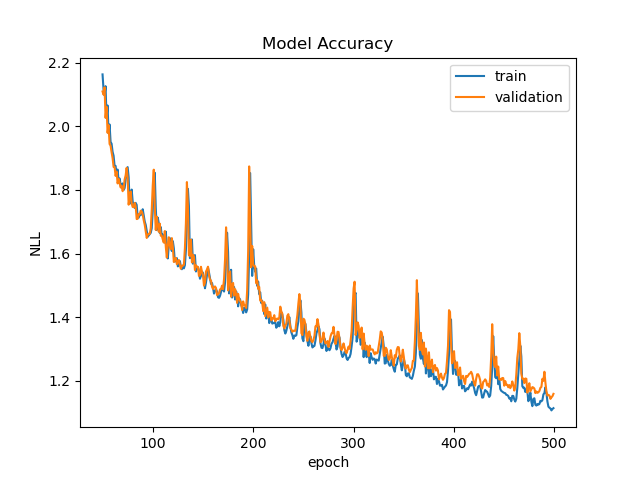

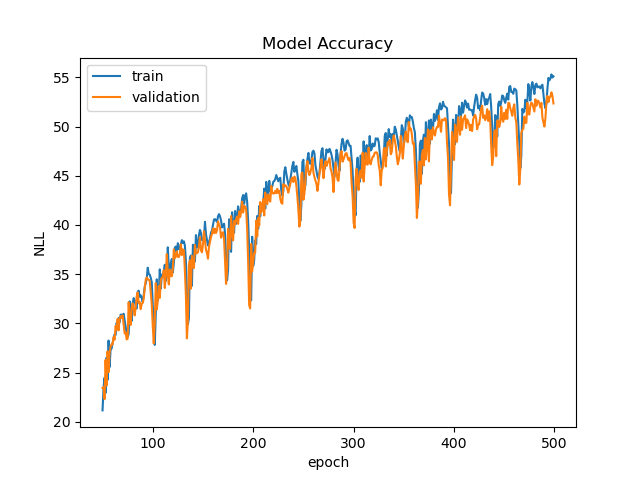

Max accuracy:  53.47560975609756


In [21]:
plot_loss(train_loss1, test_loss1, epoch=(50,-1))
plot_loss(train_accuracy1, test_accuracy1, epoch=(50, -1))
print('Max accuracy: ', np.max(test_accuracy1))

In [14]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 1]))

model2 = Net(n_inputs, n_outputs, name='classifier2', activation_func=F.gelu,
                hidden_1=420, hidden_2=350, hidden_3=0,
                kernel_size=4, stride=4, trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# train the network

train_loss2, train_accuracy2, test_loss2, test_accuracy2 = model2.train_net(
    optimizer2, criterion, X_train, y_train[:, 1].view(-1,), X_test, y_test[:, 1].view(-1,), 500)

In [ ]:
plot_loss(train_loss2, test_loss2, epoch=(50, -1))
plot_loss(train_accuracy2, test_accuracy2, epoch=(50, -1))
print('Max accuracy: ', np.max(test_accuracy2))


In [17]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = len(np.unique(target[:, 0]))
test_results = []
num_epochs = 150
# for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
for activ_f, activ_f_name in [(F.gelu, 'gelu')]:
    for kernel_size, stride in [(4, 4)]:
        for hidden_1 in [420]:
            for hidden_2 in [130, 140, 150]:
                for hidden_3 in [0]:
                    for trim_edges in [110]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f"{hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, name='classifier1', activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    kernel_size=kernel_size, stride=stride, trim_edges=trim_edges, save_best=False)
                        criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train[:, 0].view(-1), X_test, y_test[:, 0].view(-1), num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))


Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (gelu, 4, 4,420, 130, 0, 110)
Epoch 1/150: Test loss decreased (inf --> 3.686973)
Epoch 2/150: Test loss decreased (3.686973 --> 3.576376)
Epoch 3/150: Test loss decreased (3.576376 --> 3.510350)
Epoch 5/150: Test loss decreased (3.510350 --> 3.399547)
Epoch 6/150: Test loss decreased (3.399547 --> 3.294047)
Epoch 7/150: Test loss decreased (3.294047 --> 3.190039)
Epoch 8/150: Test loss decreased (3.190039 --> 3.127196)
Epoch 9/150: Test loss decreased (3.127196 --> 3.039174)
Epoch 10/150: Test loss decreased (3.039174 --> 2.946846)
Epoch 11/150: Test loss decreased (2.946846 --> 2.871865)
Epoch 12/150: Test loss decreased (2.871865 --> 2.804562)
Epoch 13/150: Test loss decreased (2.804562 --> 2.763287)
Epoch 15/150: Test loss decreased (2.763287 --> 2.741523)
Epoch 16/150: Test loss decreased (2.741523 --> 2.666706)
Epoch 17/150: Test loss decreased (2.666706 --> 2.619107)
Epoch 19/150: Test loss decreased (2.61

In [18]:
table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

+------------+-------------+--------+----------+----------+----------+------------+--------------------+
| activation | kernel size | stride | hidden_1 | hidden_2 | hidden_3 | trim_edges |      Min Loss      |
+------------+-------------+--------+----------+----------+----------+------------+--------------------+
|    gelu    |      4      |   4    |   420    |   140    |    0     |    110     | 1.4760624170303345 |
|    gelu    |      4      |   4    |   420    |   150    |    0     |    110     | 1.5034433603286743 |
|    gelu    |      4      |   4    |   420    |   130    |    0     |    110     | 1.5168848037719727 |
+------------+-------------+--------+----------+----------+----------+------------+--------------------+


In [ ]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = len(np.unique(target[:, 1]))
test_results = []
num_epochs = 150
# for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
for activ_f, activ_f_name in [(F.gelu, 'gelu')]:
    for kernel_size, stride in [(4,4)]:
        for hidden_1 in [420]:
            for hidden_2 in [350]:
                for hidden_3 in [0]:
                    for trim_edges in [120]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f"{hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, name='classifier2', activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    kernel_size=kernel_size, stride=stride, trim_edges=trim_edges, save_best=False)
                        criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train[:, 1].view(-1), X_test, y_test[:, 1].view(-1), num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))


In [ ]:
table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

In [15]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/model1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))

model1.load_state_dict(torch.load('models/model1-classifier-acc53.pt'))
model2.load_state_dict(torch.load('models/model2-classifier-acc99.pt'))


<All keys matched successfully>

In [16]:
# make predictions
random_idx = np.random.choice(np.arange(len(X_test)), size=500, replace=False)
X_validate = X_test[random_idx]
y_validate = y_test[random_idx]
y_validate_new = y_test_original[random_idx]
# print(y_validate_new)
# print(y_validate)

Phase 0: acc 0.7272727272727273
Phase 1: acc 0.25
Phase 2: acc 0.0
Phase 3: acc 0.5714285714285714
Phase 4: acc 0.6
Phase 5: acc 0.45454545454545453
Phase 6: acc 0.3333333333333333
Phase 7: acc 0.5
Phase 8: acc 0.6153846153846154
Phase 9: acc 0.6428571428571429
Phase 10: acc 0.5833333333333334
Phase 11: acc 0.6
Phase 12: acc 0.4166666666666667
Phase 13: acc 0.5333333333333333
Phase 14: acc 0.5333333333333333
Phase 15: acc 0.5
Phase 16: acc 0.5
Phase 17: acc 0.7142857142857143
Phase 18: acc 0.7333333333333333
Phase 19: acc 0.46153846153846156
Phase 20: acc 0.46153846153846156
Phase 21: acc 0.5454545454545454
Phase 22: acc 0.6666666666666666
Phase 23: acc 0.0
Phase 24: acc 0.4444444444444444
Phase 25: acc 0.7894736842105263
Phase 26: acc 0.375
Phase 27: acc 0.7142857142857143
Phase 28: acc 0.5
Phase 29: acc 0.8333333333333334
Phase 30: acc 0.3
Phase 31: acc 0.5833333333333334
Phase 32: acc 0.35714285714285715
Phase 33: acc 0.625
Phase 34: acc 0.4
Phase 35: acc 0.4166666666666667
Phase 36

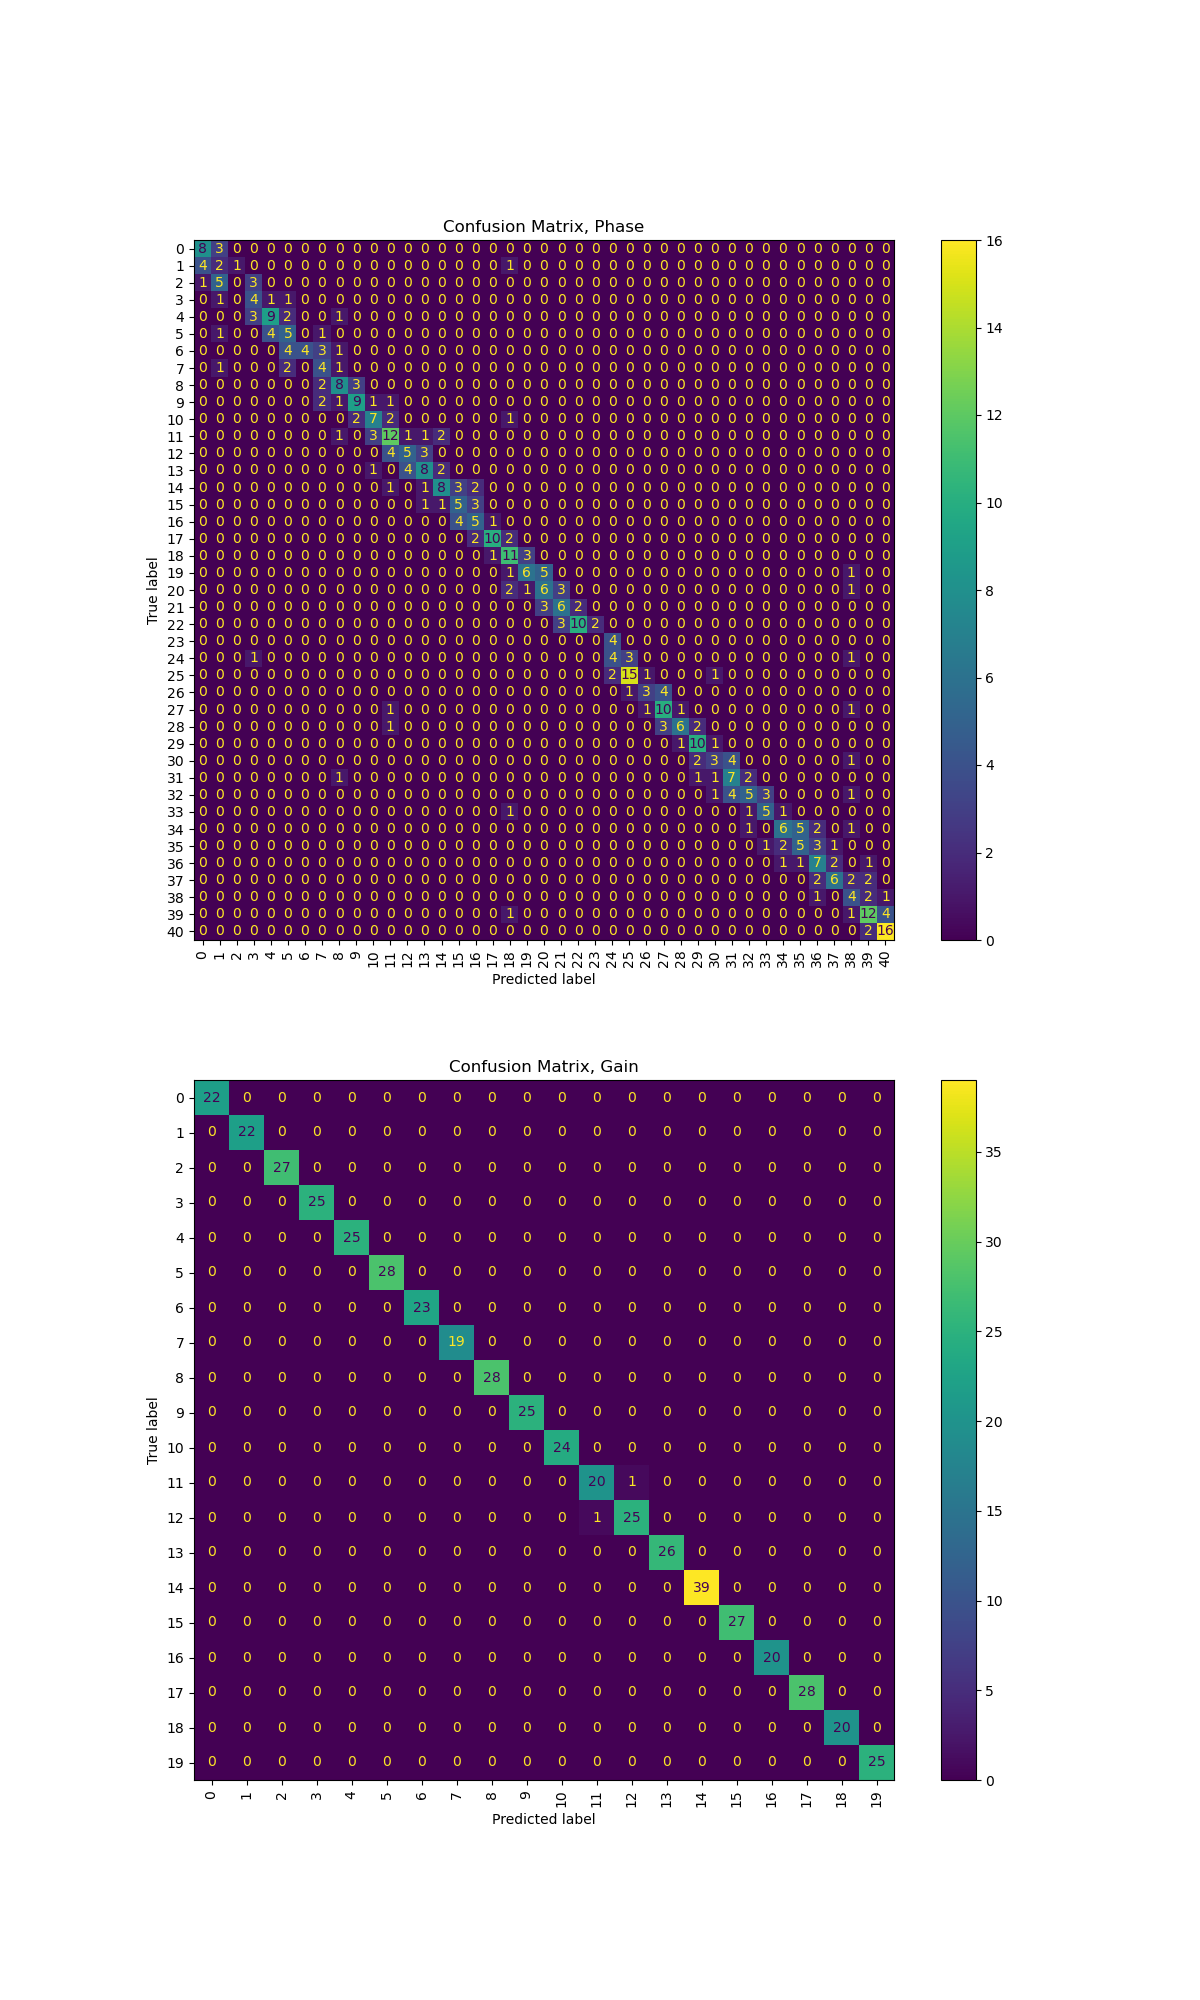

In [17]:
with torch.no_grad():
    yhat1 = model1(X_validate)
    yhat2 = model2(X_validate)

# Extract top category
_, yhat1 = torch.exp(yhat1).topk(1, dim=1)
_, yhat2 = torch.exp(yhat2).topk(1, dim=1)

# show confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, (ax1, ax2) = plt.subplots(figsize=(12, 20), nrows=2)
ax1.set_title('Confusion Matrix, Phase')
ConfusionMatrixDisplay.from_predictions(y_validate[:, 0], yhat1.ravel().numpy(), xticks_rotation='vertical', ax=ax1)

ax2.set_title('Confusion Matrix, Gain')
ConfusionMatrixDisplay.from_predictions(y_validate[:, 1], yhat2.ravel().numpy(), xticks_rotation='vertical', ax=ax2)

for i, acc in enumerate(confusion_matrix(y_validate[:, 0], yhat1.ravel().numpy(), normalize='true').diagonal()):
    print(f'Phase {i}: acc {acc}')

for i, acc in enumerate(confusion_matrix(y_validate[:, 1], yhat2.ravel().numpy(), normalize='true').diagonal()):
    print(f'Gain {i}: acc {acc}')
# Convert from category to value
yhat1 = phi_encoder.inverse_transform(yhat1.ravel().numpy())
yhat2 = gain_encoder.inverse_transform(yhat2.ravel().numpy())
yhat = np.array([yhat1, yhat2]).T.reshape(-1, 2)
yhat_new = yhat

# Descale the input values
X_validate_new = data_scaler.inverse_transform(X_validate.numpy())
#
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
x = gen_tf.frequency.astype(np.float32)

In [18]:

import torch
import torch.nn.functional as F

def curve_fit_deluxe(func, x, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        x, sample = x[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    x = torch.tensor(x).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    x = F.avg_pool1d(x, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, x, sample, **kwargs)

curve_fit_deluxe(gen_tf, x, X_validate_new[0])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

+-----+-------+-----------------------+-----------------------+-----------------------+
| idx | param |        original       |         model         |          opt          |
+-----+-------+-----------------------+-----------------------+-----------------------+
| 103 |  phi  |         -18.0         |         -17.0         |   -17.83921491043133  |
| 103 |  g_oo | 0.0027052631578947366 | 0.0027052631578947366 | 0.0026835940828048768 |
| 154 |  phi  |         -11.0         |         -13.0         |   -4.809071748262477  |
| 154 |  g_oo |  0.006352631578947369 |  0.006352631578947369 |  0.004734850505756075 |
| 376 |  phi  |          15.0         |          15.0         |   6.505169318401395   |
| 376 |  g_oo |  0.004268421052631579 |  0.004268421052631579 |  0.00472959521003164  |
+-----+-------+-----------------------+-----------------------+-----------------------+


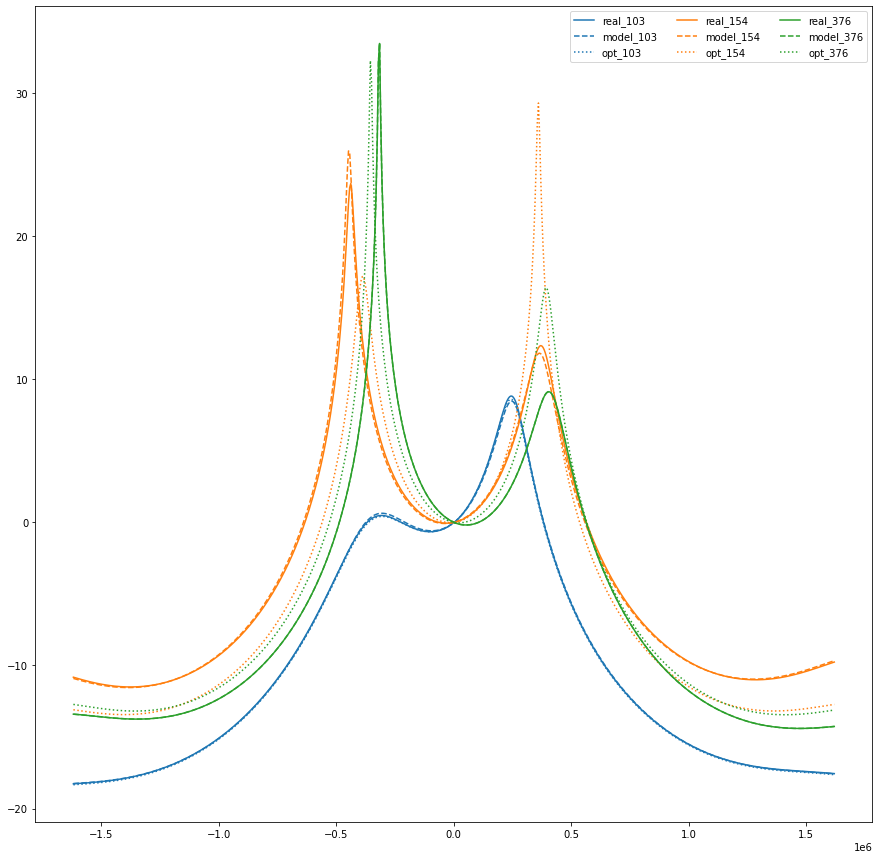

In [19]:
# plot the validation curves
%matplotlib inline

plt.figure(figsize=(15, 15))

table = PrettyTable()
table.field_names = ["idx", "param", "original", "model", "opt"] #, "model+opt"]
# print(table)

for idx in np.random.choice(np.arange(0, len(X_validate_new)), size=3):
    try:
        popt, _  = curve_fit_deluxe(gen_tf, x, X_validate_new[idx], trim_edges=130, kernel_size=4, stride=1,
                                    bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
        # Initial guesses coming from the model
        # poptModel,_ = curve_fit(gen_tf, x, X_validate_new[idx], bounds=([-20, 1e-4], [20, 1e-2]), method='trf', p0=yhat_new[idx])
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue

    # print('Param, Original, Model, Optimizer')
    table.add_row([idx, 'phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0]]) #, poptModel[0]])
    table.add_row([idx, 'g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1]]) #, poptModel[1]])

    # print('phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0])
    # print('g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1])

    p = plt.plot(x, gen_tf(x, *(y_validate_new[idx])), label=f'real_{idx}', ls='-')
    plt.plot(x, gen_tf(x, *(yhat_new[idx])), label=f'model_{idx}', ls='--', color=p[0].get_color())
    plt.plot(x, gen_tf(x, *popt), label=f'opt_{idx}', ls=':', color=p[0].get_color())
    # plt.plot(x, gen_tf(x, *poptModel), label=f'opt+model_{idx}', ls='-.', color=p[0].get_color())
print(table)
plt.legend(ncol=3);
# plt.show()
# plt.close()

In [22]:
def calc_mae_model(yhat, yreal):

    return np.abs(np.mean(np.abs(yhat-yreal), axis=0)/ np.max(yreal, axis=0))

def calc_mae_optimize(test_x, test_y, trim_edges=0, kernel_size=1, stride=1):
    gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
    x = gen_tf.frequency.astype(np.float32)
    coeffs = []
    real = []
    for xi, yi in zip(test_x, test_y):
        try:
            popt, pcov  = curve_fit_deluxe(gen_tf, x, xi, trim_edges=trim_edges,
                                           kernel_size=kernel_size, stride=stride,
                                           bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
        except:
            # print(f'Scipy curve fit failed for idx: {idx}')
            continue
        coeffs.append(popt)
        real.append(yi)
    yhat = np.array(coeffs)
    real = np.array(real)
    return np.abs(np.mean(np.abs(yhat - real), axis=0)/ np.max(real, axis=0))


In [23]:
mae_model = calc_mae_model(yhat_new, y_validate_new)
mae_optimize = calc_mae_optimize(X_validate_new, y_validate_new, trim_edges=130, kernel_size=4, stride=1)
# mae_optimize_model = calc_mae_optimize_model(yhat_new, X_validate_new, y_validate_new)
print('Model mae: ', mae_model)
print('Optimize mae: ', mae_optimize)
# print('Optimize+Model mae: ', mae_optimize_model)

Model mae:  [0.0432     0.00041684]
Optimize mae:  [0.20681395 0.16423997]


In [54]:
test_results = []
for trim_edges in [0, 100, 130]:
    for kernel_size, stride in [(1,1), (4,1), (4,4)]:
        print(f"Testing optimizer with: trim_edges, kernel_size, stride, "
            f"= ({trim_edges}, {kernel_size}, {stride})")
        res = calc_mae_optimize(X_validate_new, y_validate_new, trim_edges=trim_edges, kernel_size=kernel_size, stride=stride)
        test_results.append([trim_edges, kernel_size, stride, res[0], res[1]])

Testing optimizer with: trim_edges, kernel_size, stride, = (0, 1, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (0, 4, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (0, 4, 4)
Testing optimizer with: trim_edges, kernel_size, stride, = (100, 1, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (100, 4, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (100, 4, 4)
Testing optimizer with: trim_edges, kernel_size, stride, = (130, 1, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (130, 4, 1)
Testing optimizer with: trim_edges, kernel_size, stride, = (130, 4, 4)


In [55]:
table = PrettyTable()
table.field_names = ["trim_edges", "kernel size", "stride", "Loss Phi", "Loss Gain"]
# print(test_results)
test_results.sort(key=lambda x: np.abs(x[-2] + x[-1]))
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

+------------+-------------+--------+---------------------+---------------------+
| trim_edges | kernel size | stride |       Loss Phi      |      Loss Gain      |
+------------+-------------+--------+---------------------+---------------------+
|    130     |      4      |   1    | 0.19449137633619168 | 0.16061078474023235 |
|    130     |      4      |   4    |  0.1944236092347697 | 0.17106378345219067 |
|    130     |      1      |   1    | 0.20039945967490147 |  0.1657807051878679 |
|    100     |      4      |   4    |  0.1915043698187116 | 0.18758920524257522 |
|    100     |      4      |   1    |  0.2110514130529253 | 0.17651401584863413 |
|    100     |      1      |   1    |  0.2098348533505009 | 0.18016524195165373 |
|     0      |      4      |   4    |  0.1949446434863851 | 0.20614696556228096 |
|     0      |      1      |   1    | 0.22333243022745164 |  0.2065953795188629 |
|     0      |      4      |   1    | 0.22995352040649472 | 0.20681222252396136 |
+------------+--